In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%config InlineBackend.figure_format = 'retina'

from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
import kaggle
from sklearn.metrics import make_scorer 

# ignore Warning
import warnings
warnings.filterwarnings("ignore") 

In [2]:
train = pd.read_csv('files_csv/train.csv')
test = pd.read_csv('files_csv/test.csv')

print(train.shape)
print(test.shape)

train.columns.values

(1460, 81)
(1459, 80)


array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'Pav

In [3]:
train_ID = train['Id']
test_ID = test['Id']
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

## Analyse SalePrice

In [4]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

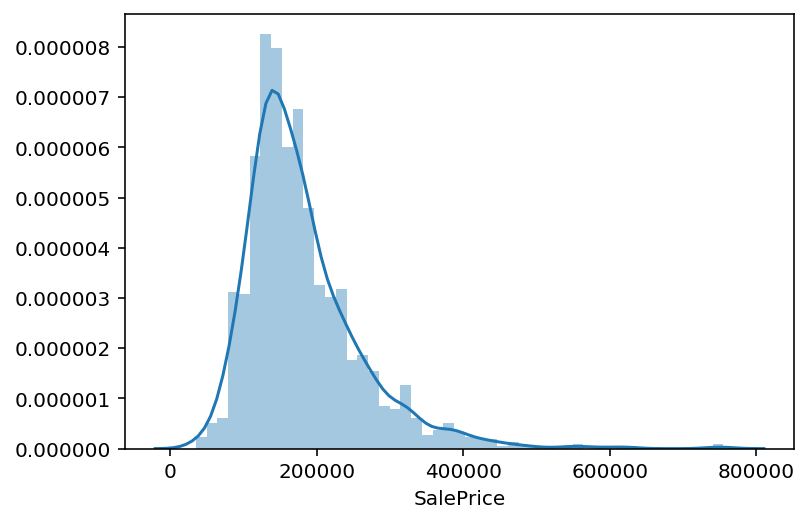

In [5]:
sns.distplot(train['SalePrice'])

log(SalePrice) pour une distribution "normale"

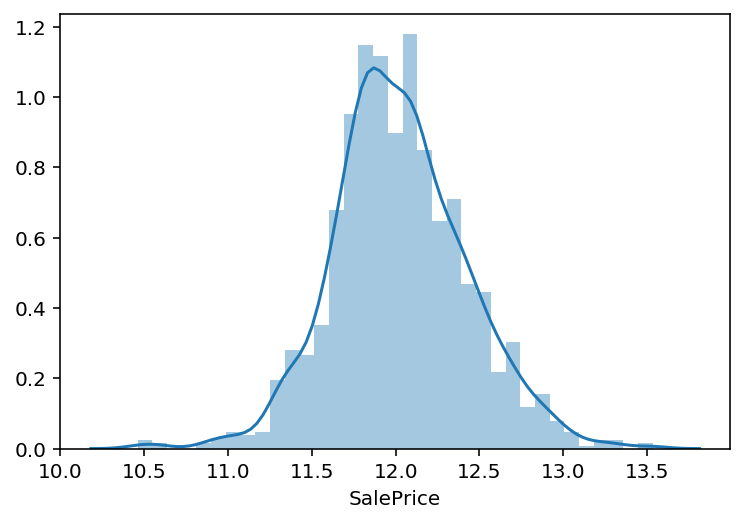

In [6]:
train['SalePrice'] = np.log1p(train['SalePrice'])
sns.distplot(train['SalePrice'])

## Division des datas en valeurs numériques ( quantitative ) et catégorielles ( qualititative ) 

In [7]:
train.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice        float64
Length: 80, dtype: object

In [8]:
# quali
qual = train.select_dtypes(include=['object']).columns
print(qual)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [9]:
#quanti
quan = train.select_dtypes(include=['int64','float64']).columns
quan = quan.drop(pd.Index(['SalePrice']))
print(quan)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


In [10]:
num_quan = len(train.select_dtypes(include=['int64','float64']).columns)
num_qual = len(train.select_dtypes(include=['object']).columns)

print(f"{num_quan} features numériques & {num_qual} features catégorielles")

37 features numériques & 43 features catégorielles


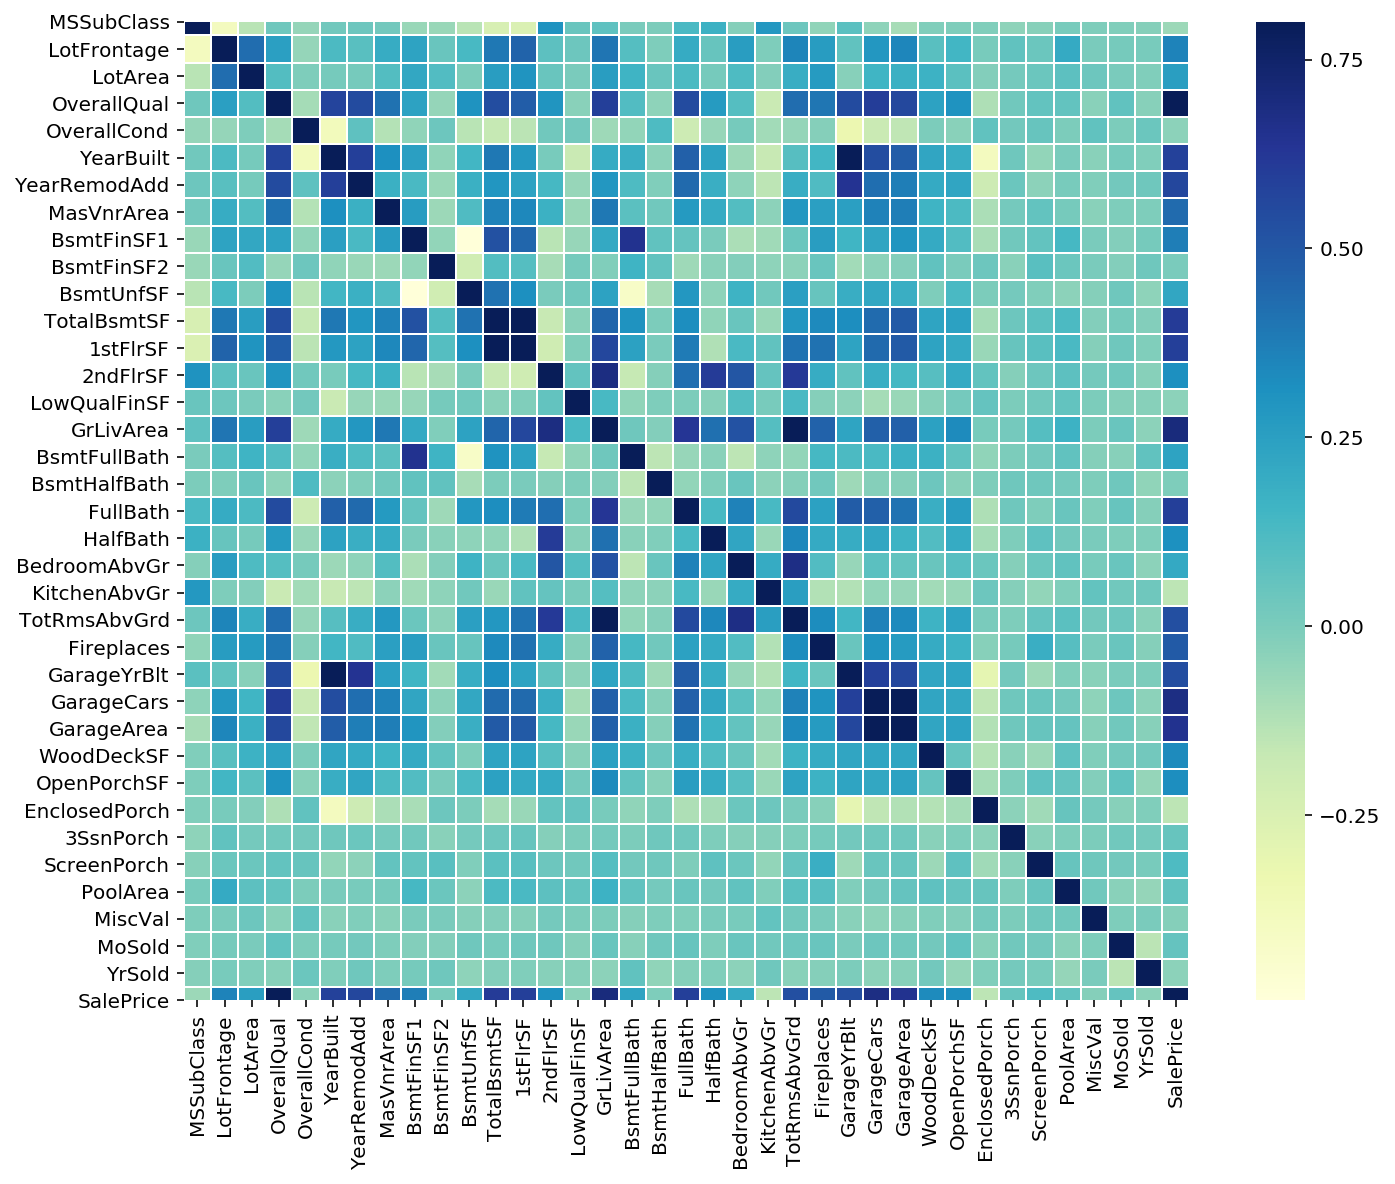

In [11]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, linewidths=.5, cmap="YlGnBu");

## 10 Features + corrélées avec l'output

In [12]:
train[quan]
corr_output = dict()

for x in train[quan]:
    corr_output[x] = round(train[x].corr(train['SalePrice']),2)
    
for key in sorted(corr_output,key =corr_output.get, reverse=True):
    if corr_output[key] >= 0.5:
            print(key, corr_output[key])  
            

# corr_mat de ces 10 features

k = 11
cols = corrmat.nlargest(k,'SalePrice').index
cols 

corr_mat_10 = train[cols].corr()
corr_mat_10

OverallQual 0.82
GrLivArea 0.7
GarageCars 0.68
GarageArea 0.65
TotalBsmtSF 0.61
1stFlrSF 0.6
YearBuilt 0.59
FullBath 0.59
YearRemodAdd 0.57
GarageYrBlt 0.54
TotRmsAbvGrd 0.53


,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,GarageYrBlt
SalePrice,1.000000,0.817185,0.700927,0.680625,0.650888,0.612134,0.596981,0.594771,0.586570,0.565608,0.541073
OverallQual,0.817185,1.000000,0.593007,0.600671,0.562022,0.537808,0.476224,0.550600,0.572323,0.550684,0.547766
GrLivArea,0.700927,0.593007,1.000000,0.467247,0.468997,0.454868,0.566024,0.630012,0.199010,0.287389,0.231197
GarageCars,0.680625,0.600671,0.467247,1.000000,0.882475,0.434585,0.439317,0.469672,0.537850,0.420622,0.588920
GarageArea,0.650888,0.562022,0.468997,0.882475,1.000000,0.486665,0.489782,0.405656,0.478954,0.371600,0.564567
TotalBsmtSF,0.612134,0.537808,0.454868,0.434585,0.486665,1.000000,0.819530,0.323722,0.391452,0.291066,0.322445
1stFlrSF,0.596981,0.476224,0.566024,0.439317,0.489782,0.819530,1.000000,0.380637,0.281986,0.240379,0.233449
FullBath,0.594771,0.550600,0.630012,0.469672,0.405656,0.323722,0.380637,1.000000,0.468271,0.439046,0.484557
YearBuilt,0.586570,0.572323,0.199010,0.537850,0.478954,0.391452,0.281986,0.468271,1.000000,0.592855,0.825667
YearRemodAdd,0.565608,0.550684,0.287389,0.420622,0.371600,0.291066,0.240379,0.439046,0.592855,1.000000,0.642277


- OverallQual : Evalue les matériaux et la finition de la maison
- GrLivArea : Surface habitable ( pieds carrés ) 
- GarageCars : Capacité du garage en nombres de voitures
- GarageArea : Taille du garage en pieds carrés
- TotalBsmSF : Superficie du sous sol ( pieds carrés ) 
- 1stFrlSF : Superficie du premier étage ( pieds carrés ) 
- FullBath : Salles de bains ( qui ne sont pas au sous sol ) 
- TotalRmsAbvGrd : Total de pieces au niveau du sol ( ne comprend pas les salles de bains ) 
- YearBuild : Année de construction
- YearRemodAdd : Date " remodelage " ( ? ) ( identique à la date de constructions si aucun ajout ) 

## Analyse features numériques

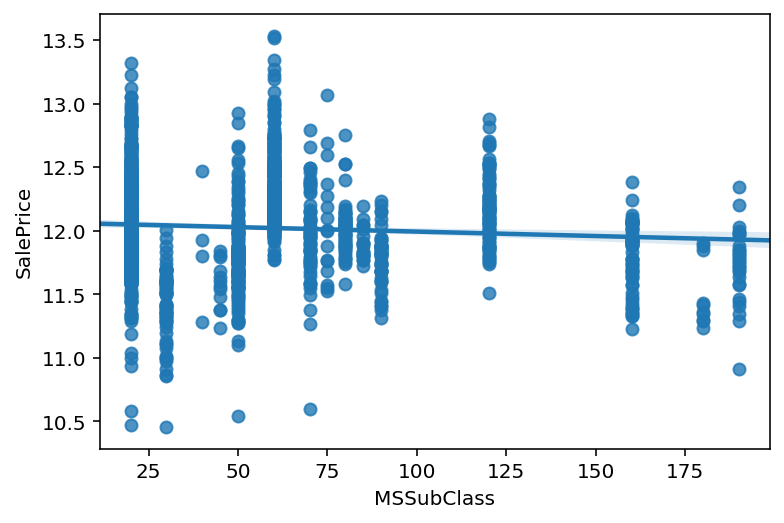

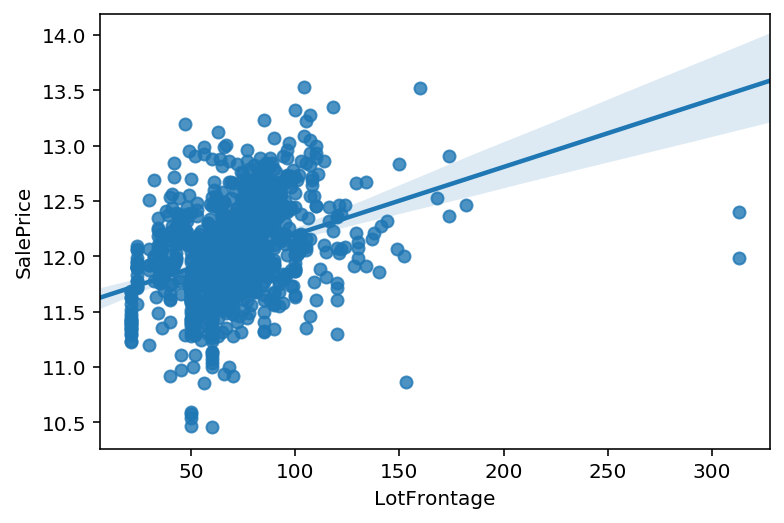

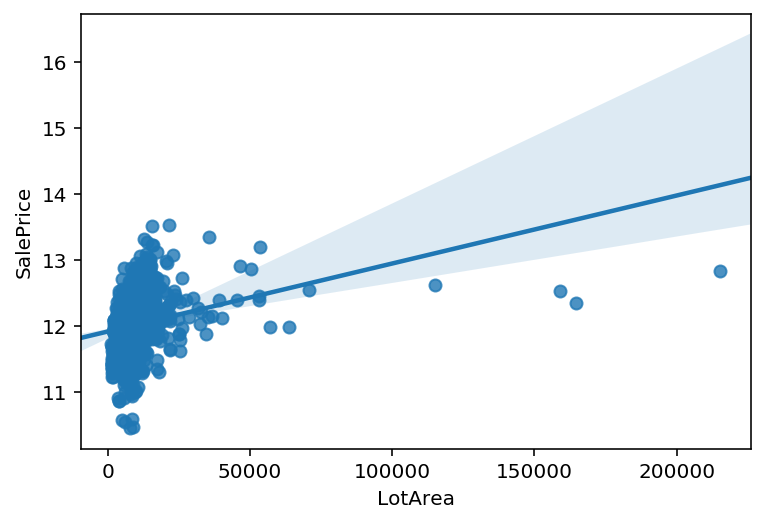

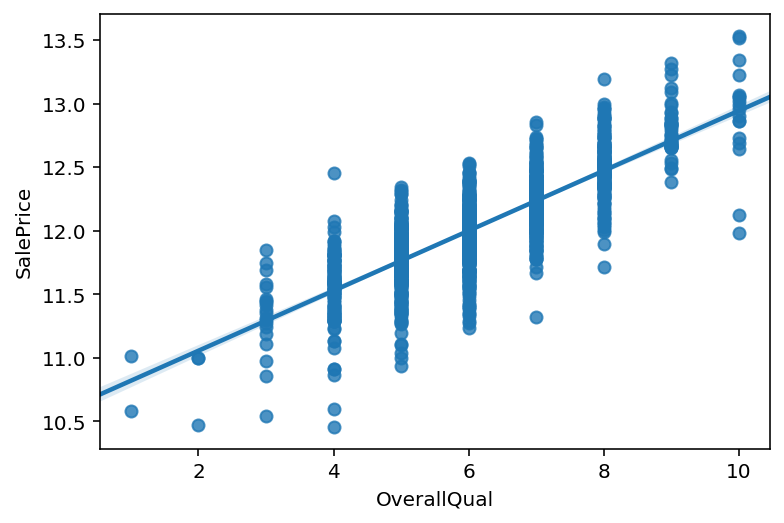

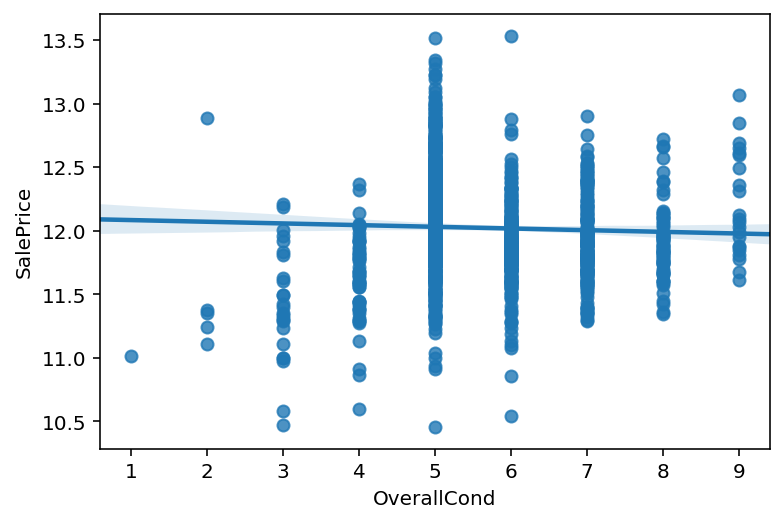

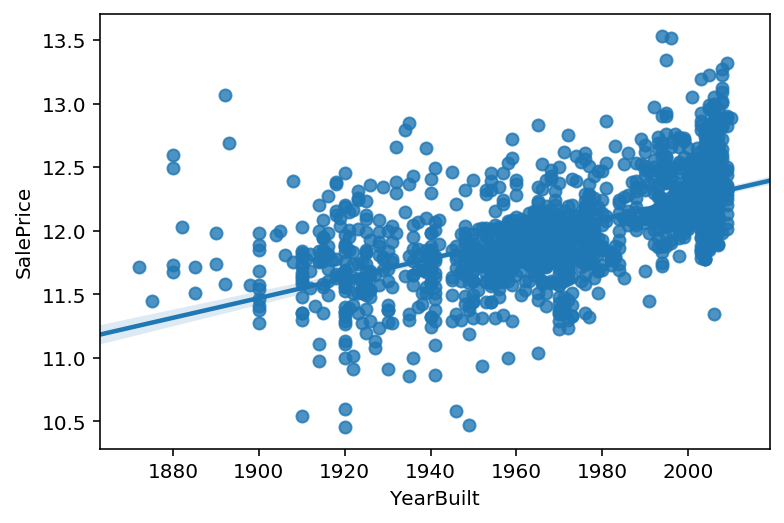

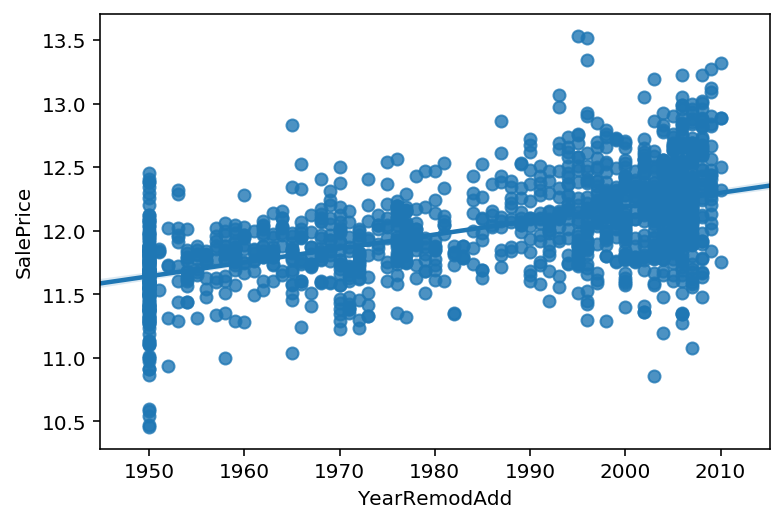

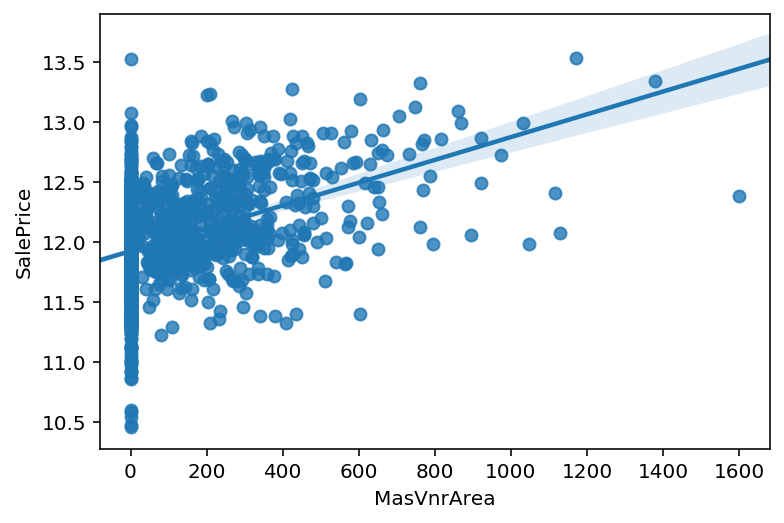

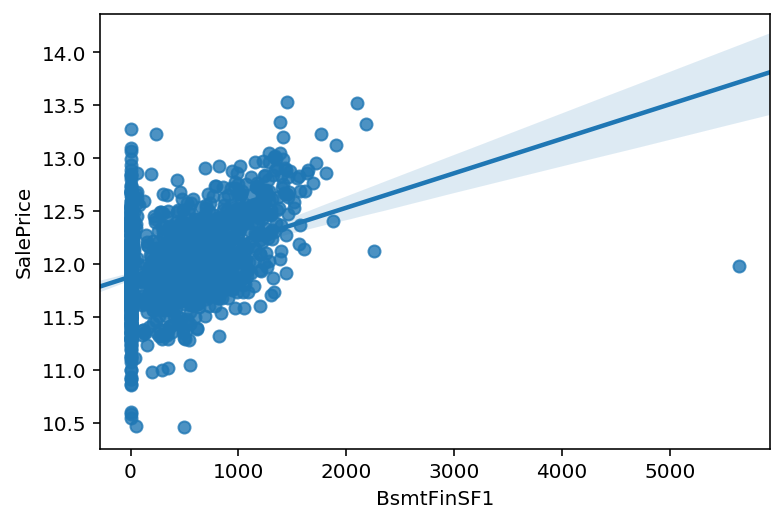

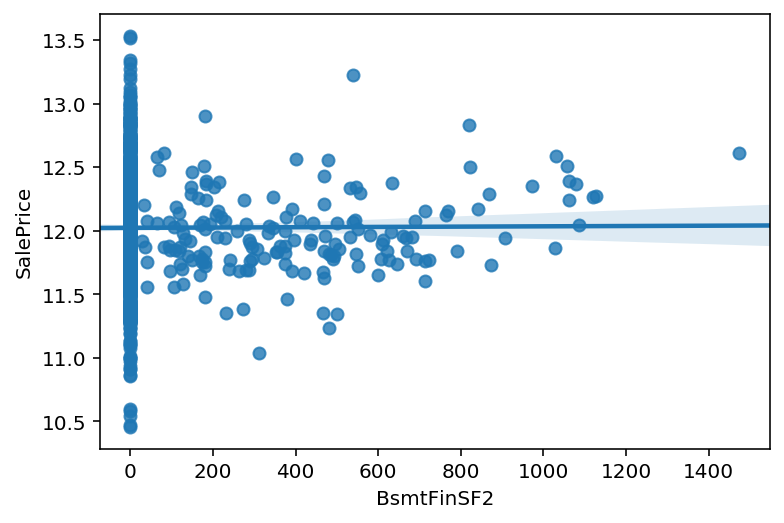

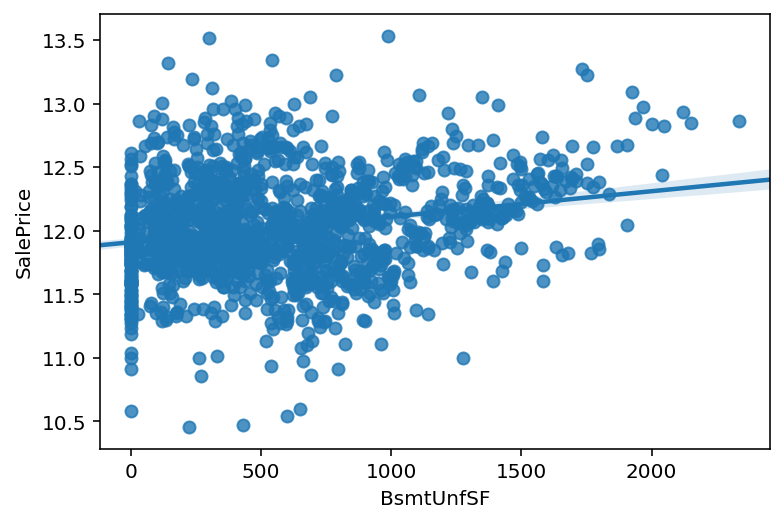

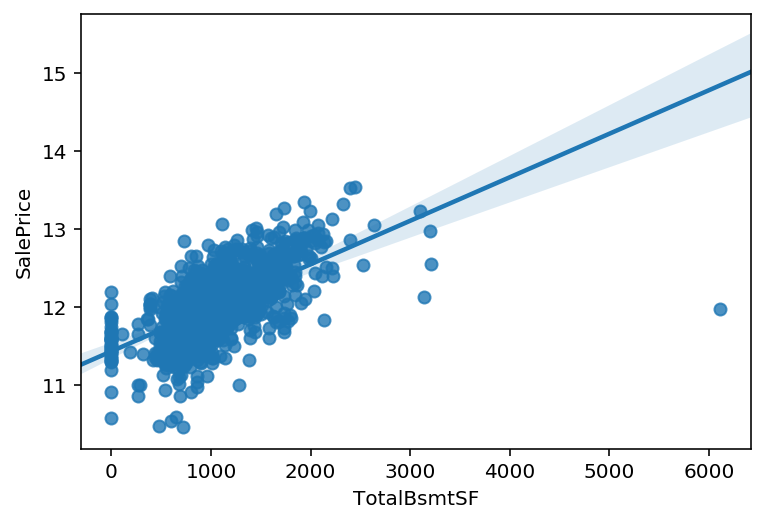

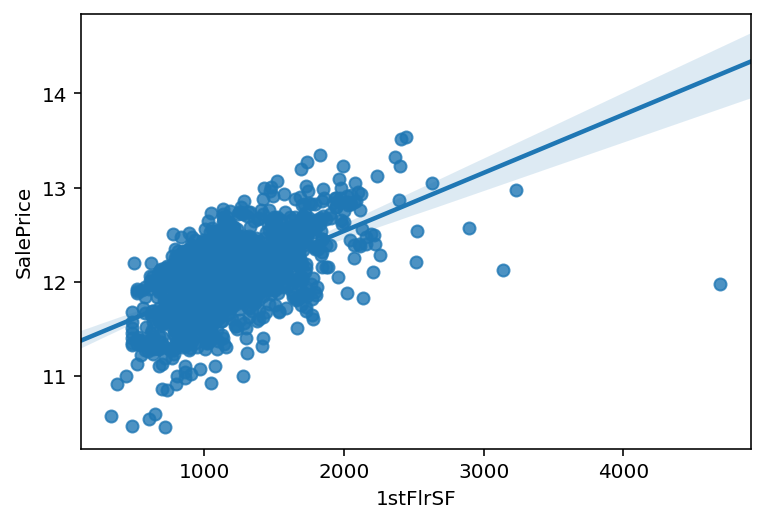

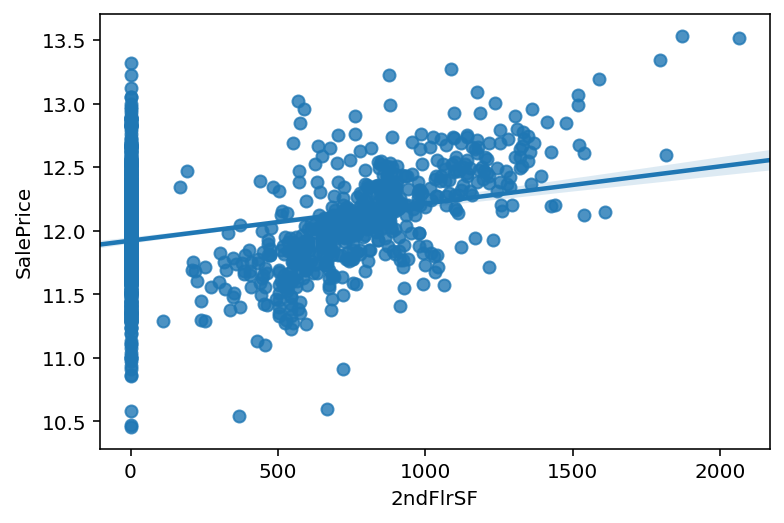

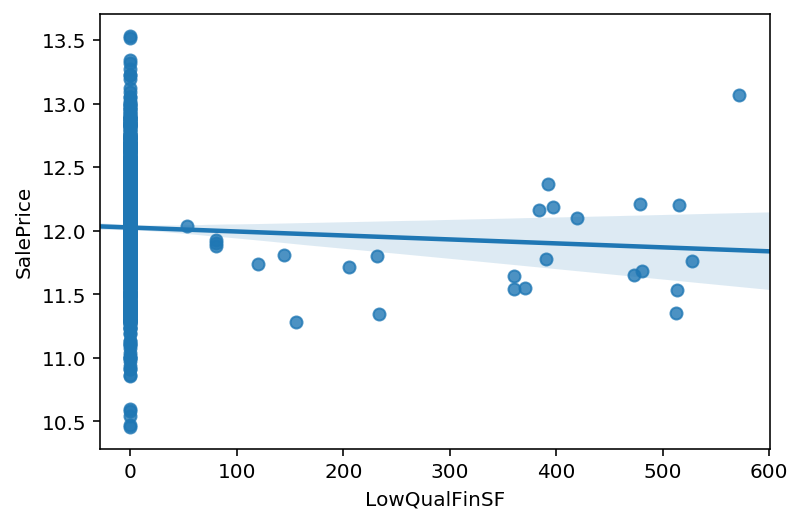

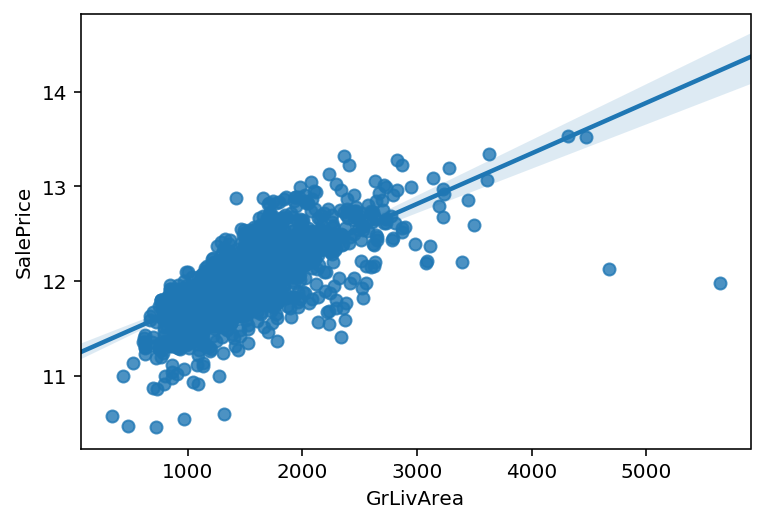

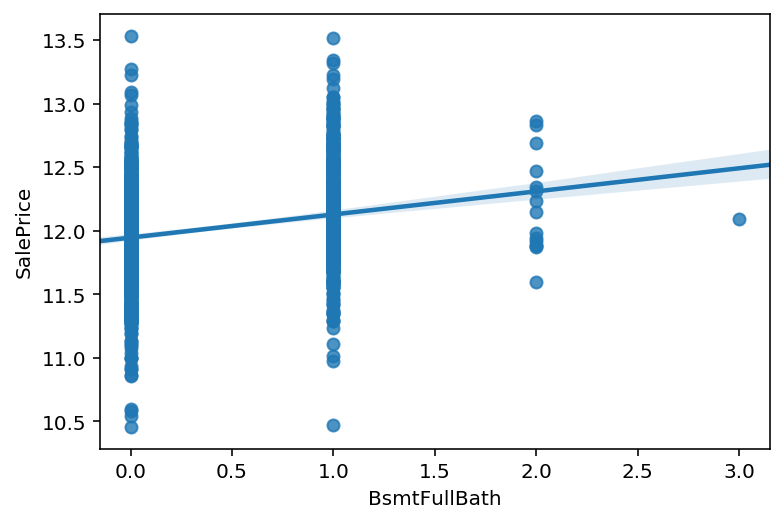

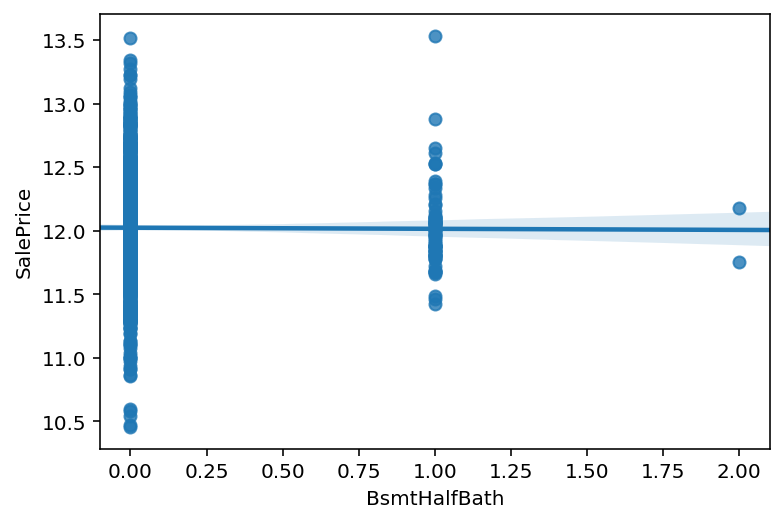

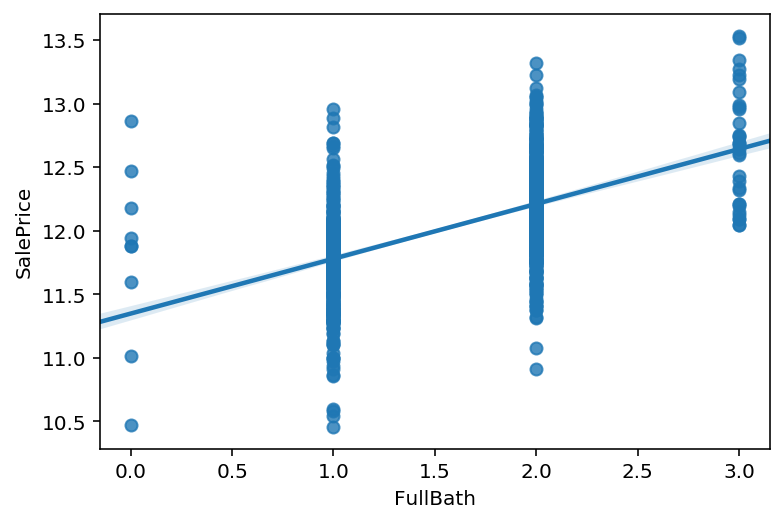

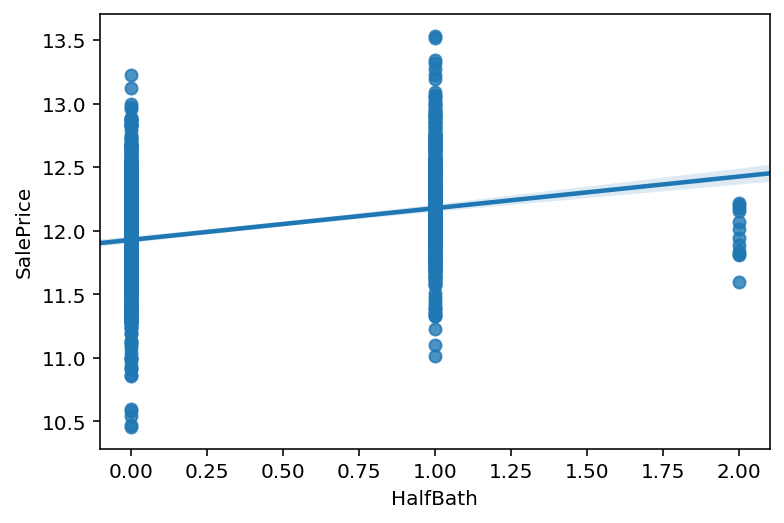

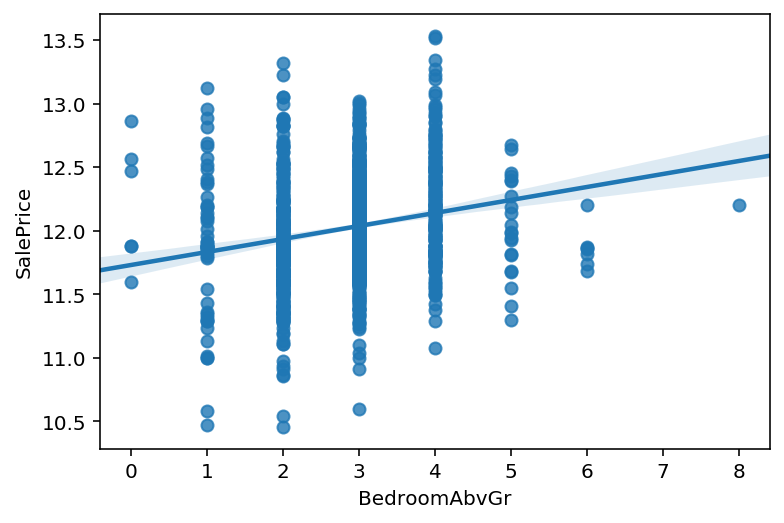

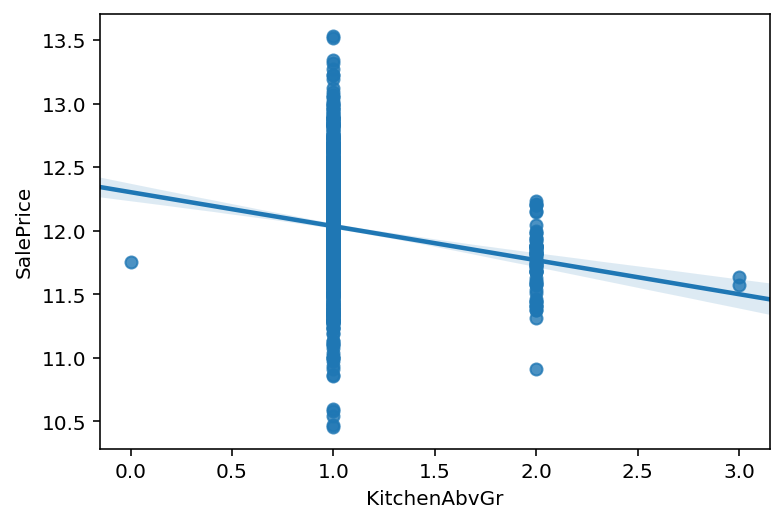

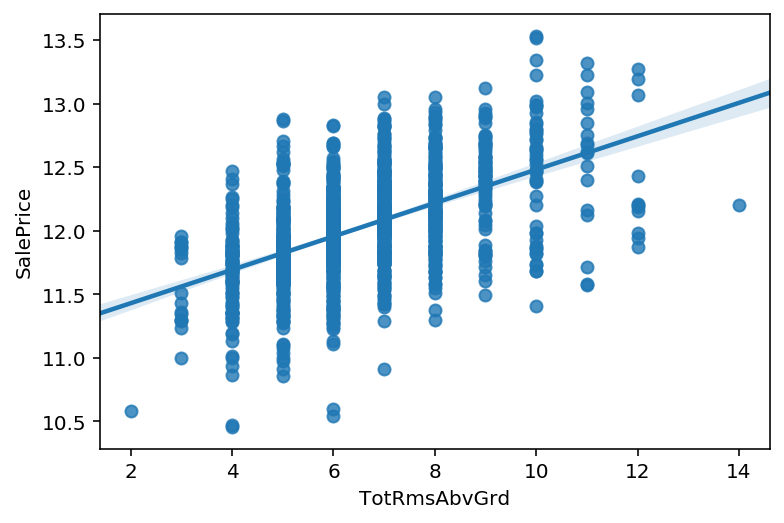

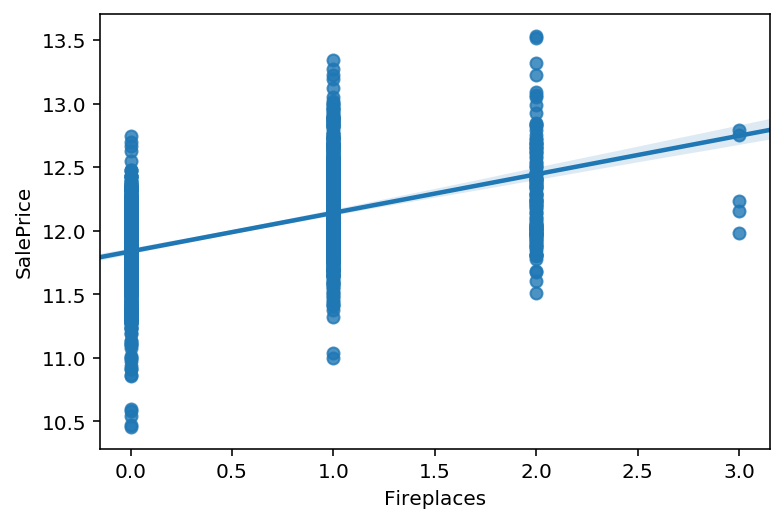

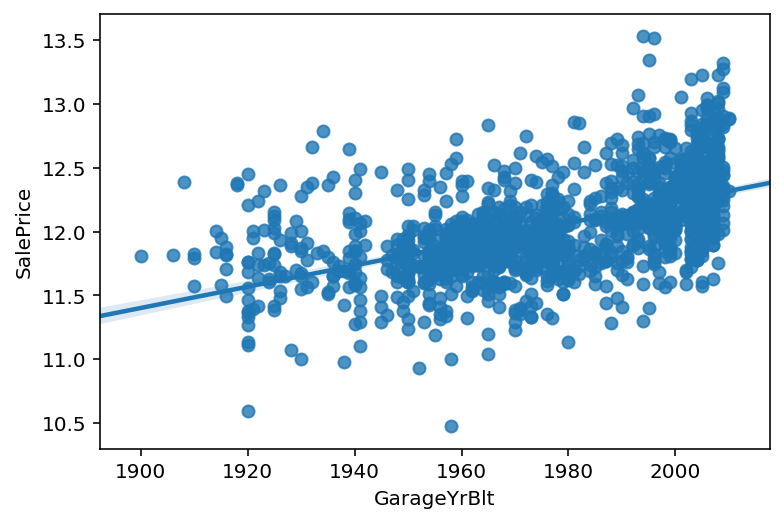

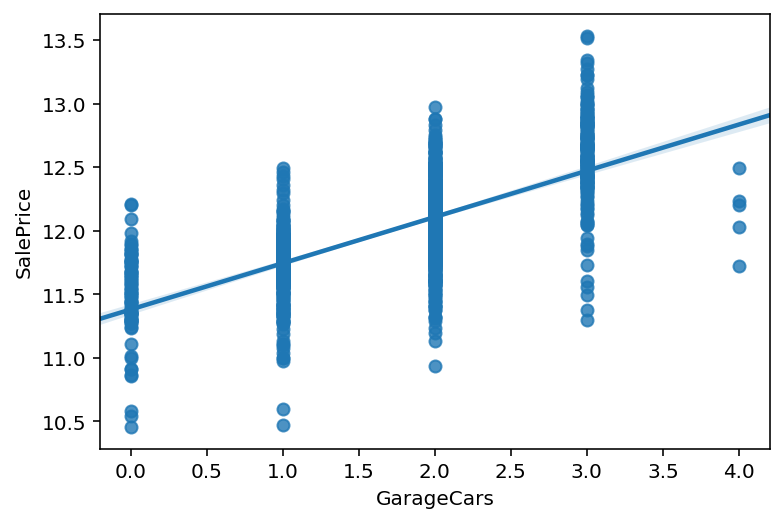

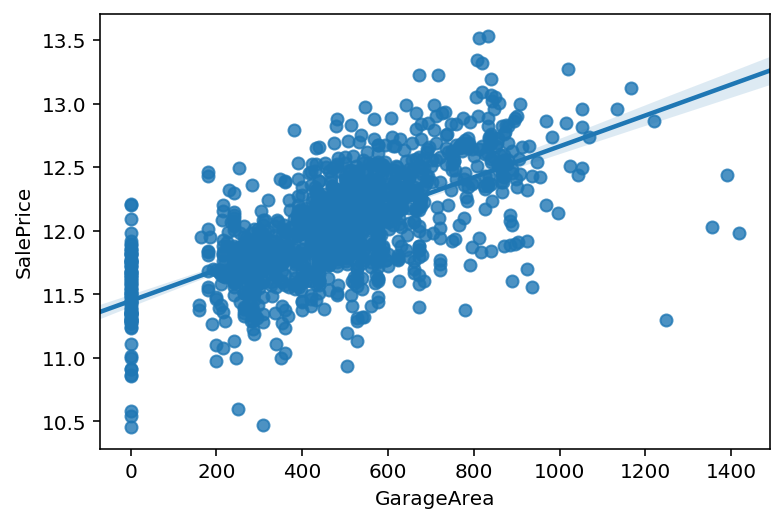

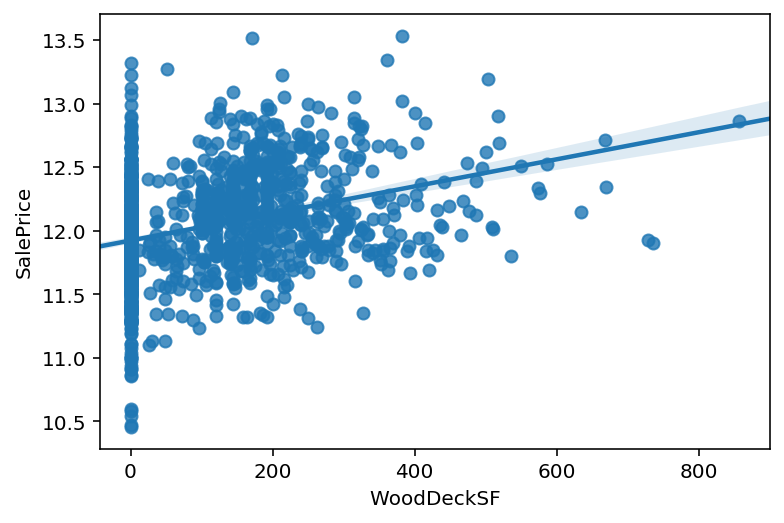

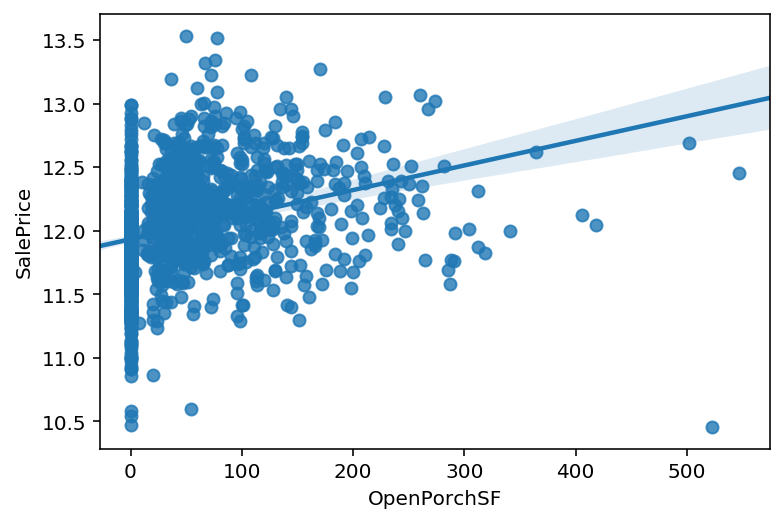

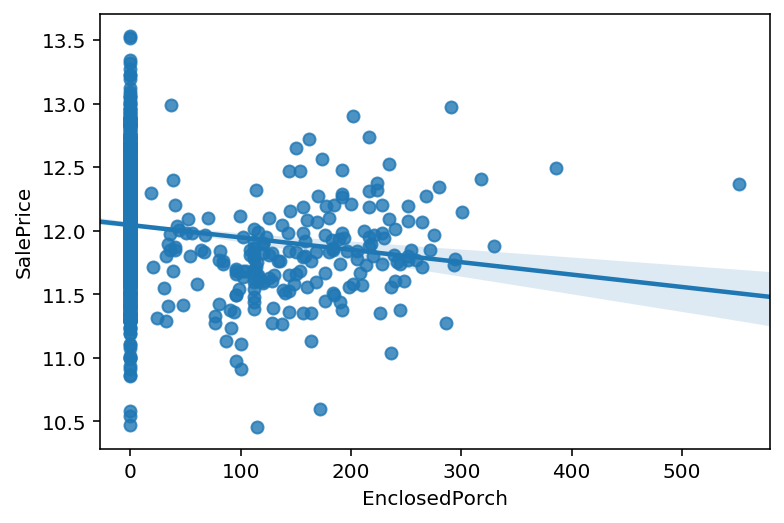

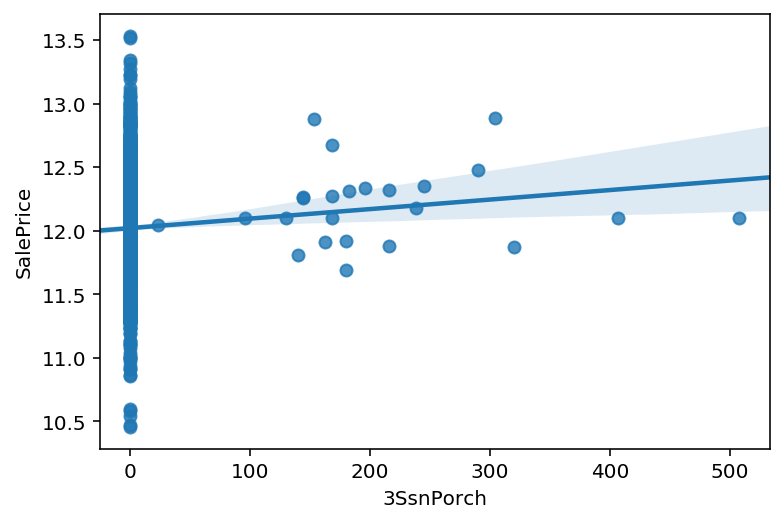

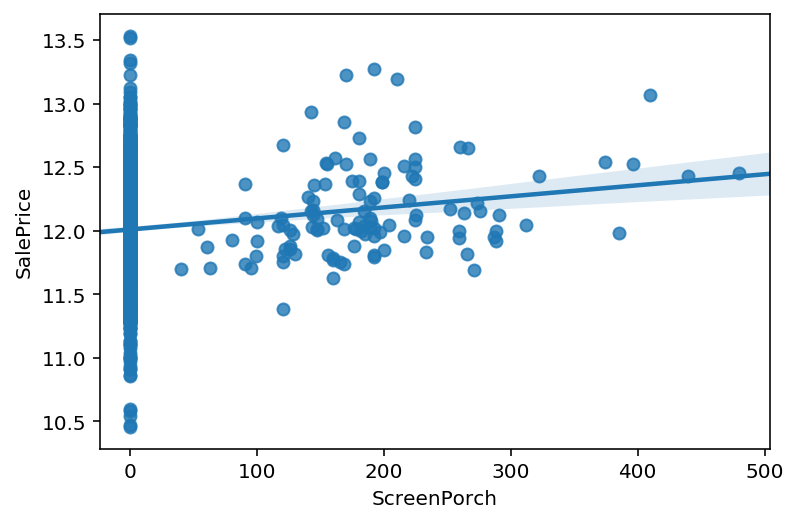

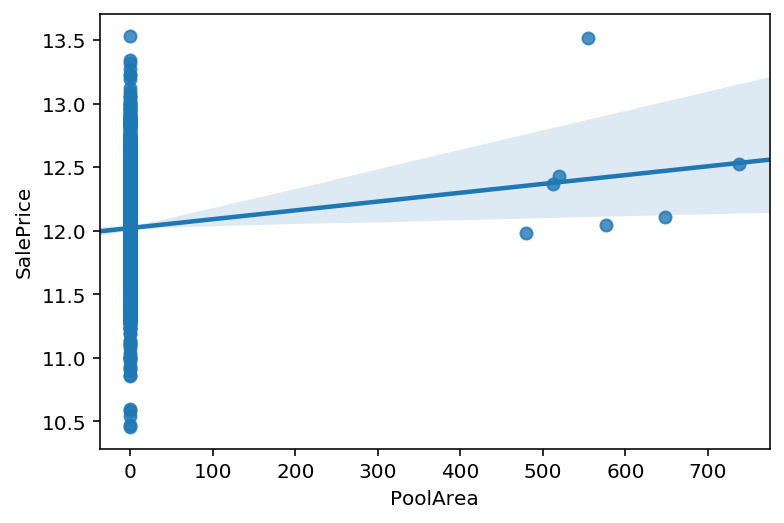

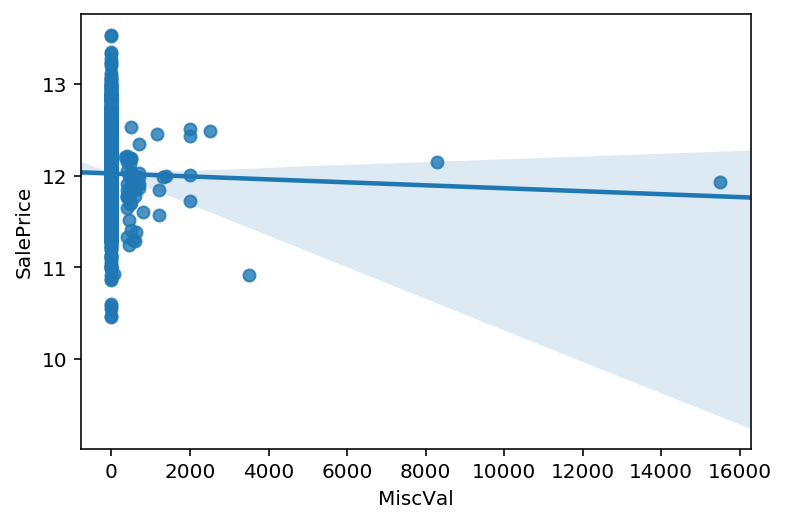

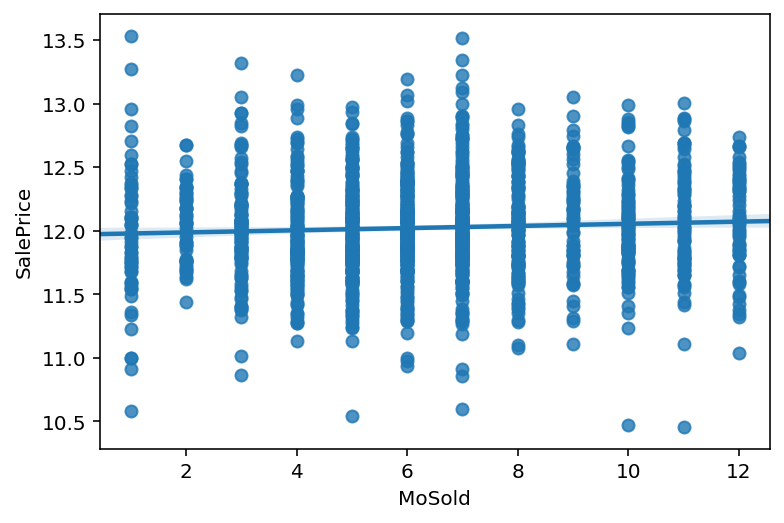

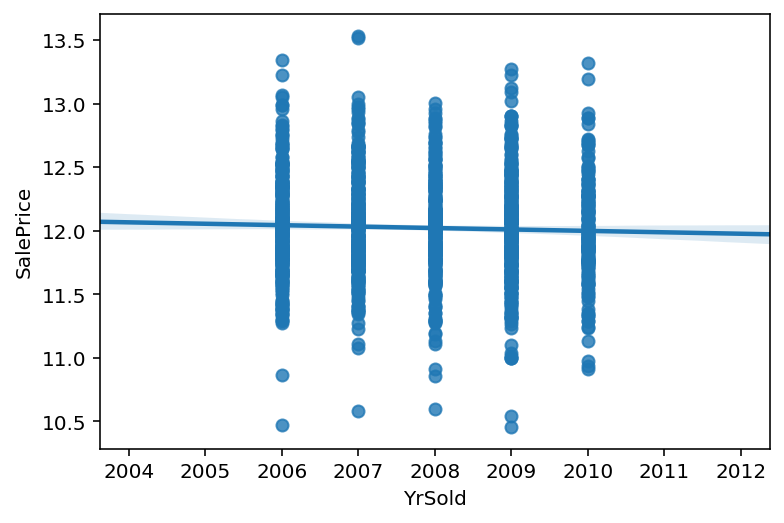

In [13]:
for feature in train[quan]:
    sns.regplot(x=feature,y='SalePrice', data=train)
    plt.show()

### Certaines features semblent avoir des outliers , Analyse une par une

* #### LotFrontage


corr : 0.36


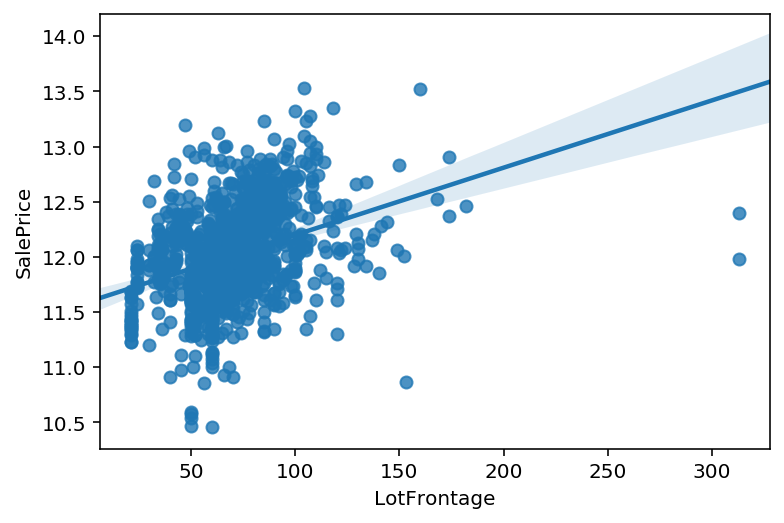

In [14]:
sns.regplot(x='LotFrontage',y='SalePrice', data=train)
print(f"corr : {round(train['LotFrontage'].corr(train['SalePrice']),2)}")

corr : 0.38


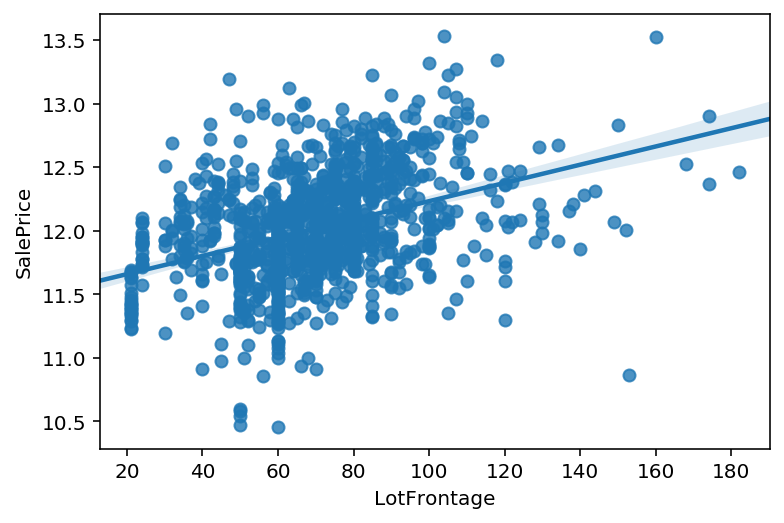

In [15]:
train = train.drop(train[(train['LotFrontage']>300)].index).reset_index(drop=True)
sns.regplot(x='LotFrontage',y='SalePrice', data=train)
print(f"corr : {round(train['LotFrontage'].corr(train['SalePrice']),2)}")

Suppression de deux outliers , augmentation de la corrélation

* #### LotArea

corr : 0.26


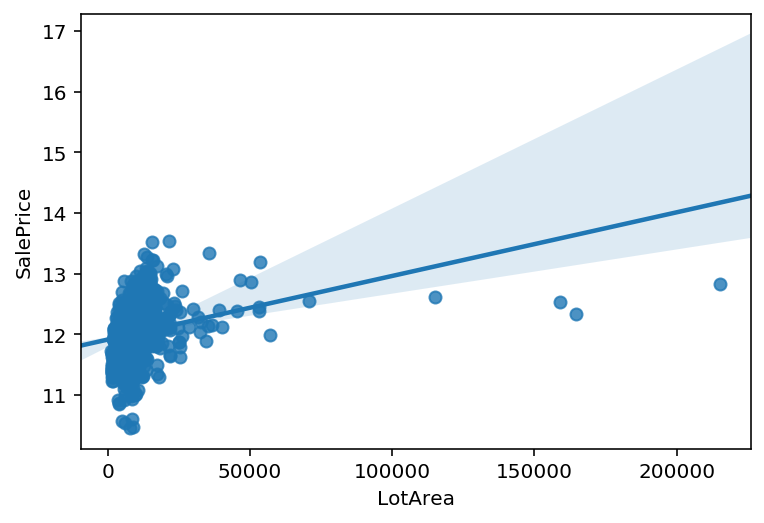

In [16]:
sns.regplot(x='LotArea',y='SalePrice', data=train)
print(f"corr : {round(train['LotArea'].corr(train['SalePrice']),2)}")

Outliers quand LotArea > 150k

corr : 0.34


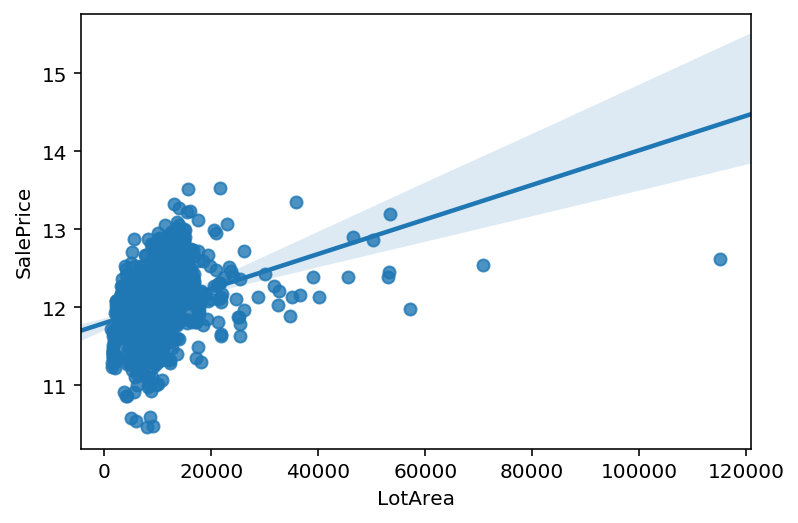

In [17]:
train = train.drop(train[(train['LotArea']>150000)].index).reset_index(drop=True)
sns.regplot(x='LotArea',y='SalePrice', data=train)
print(f"corr : {round(train['LotArea'].corr(train['SalePrice']),2)}")

* #### BsmtFinSF1

corr : 0.39


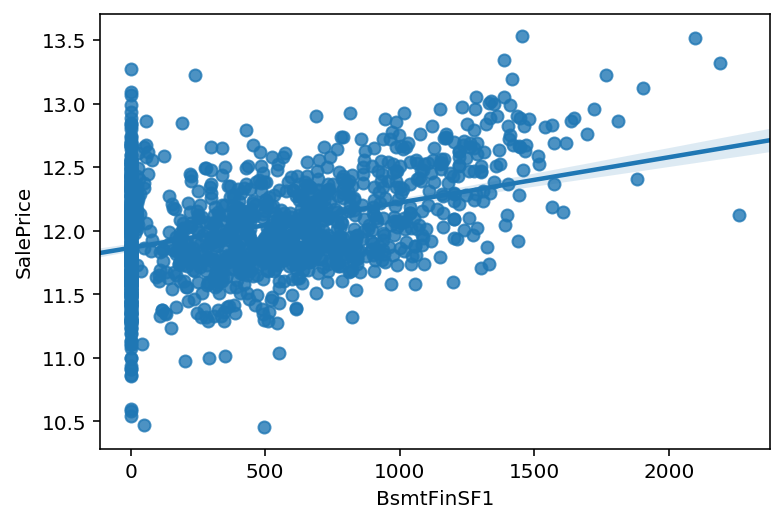

In [18]:
sns.regplot(x='BsmtFinSF1',y='SalePrice', data=train)
print(f"corr : {round(train['BsmtFinSF1'].corr(train['SalePrice']),2)}")

corr : 0.39


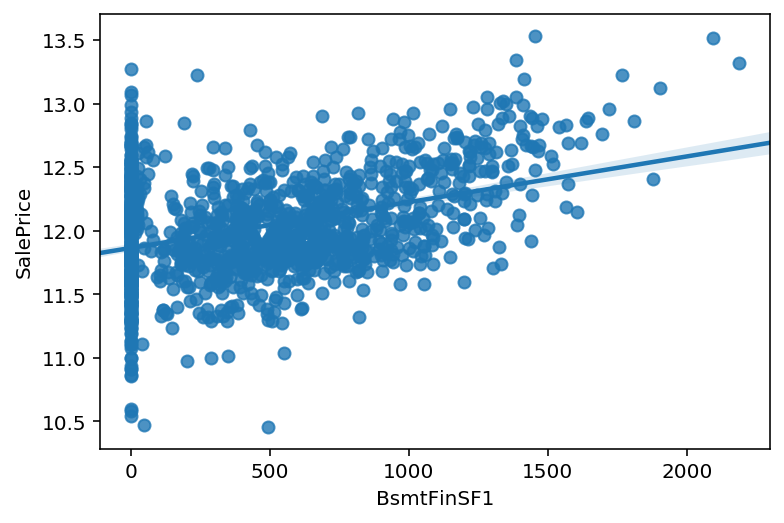

In [19]:
train = train.drop(train[(train['BsmtFinSF1']>2000) & (train['SalePrice']<12.5)].index).reset_index(drop=True)
sns.regplot(x='BsmtFinSF1',y='SalePrice', data=train)
print(f"corr : {round(train['BsmtFinSF1'].corr(train['SalePrice']),2)}")

Apparament pas trop d'impact

* #### GarageArea

corr : 0.66


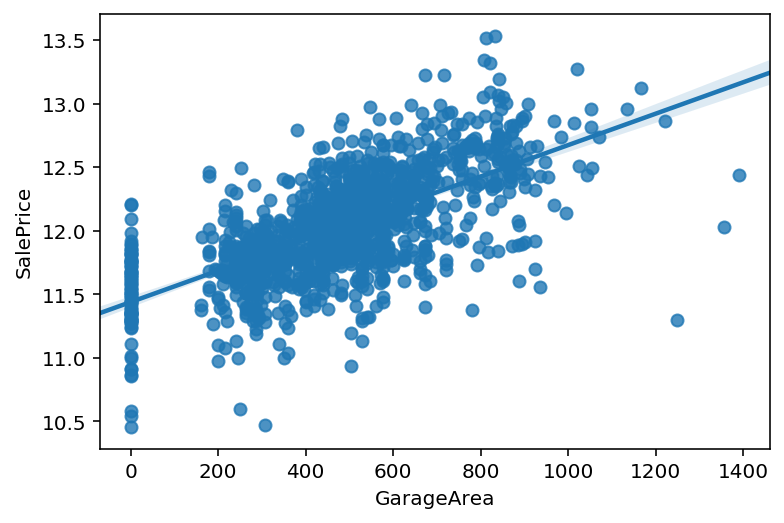

In [20]:
sns.regplot(x='GarageArea',y='SalePrice', data=train)
print(f"corr : {round(train['GarageArea'].corr(train['SalePrice']),2)}")

corr : 0.67


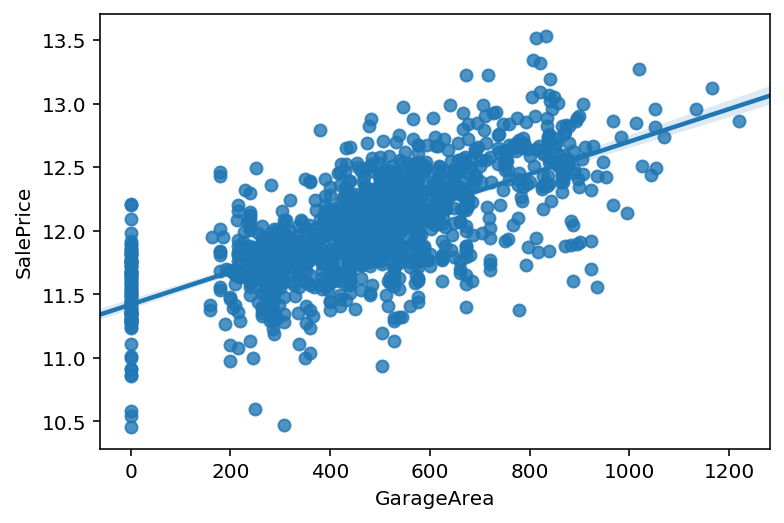

In [21]:
train = train.drop(train[(train['GarageArea']>1200) & (train['SalePrice']<12.5)].index).reset_index(drop=True)
sns.regplot(x='GarageArea',y='SalePrice', data=train)
print(f"corr : {round(train['GarageArea'].corr(train['SalePrice']),2)}")

Amélioration de la corrélation

* #### GarageCars

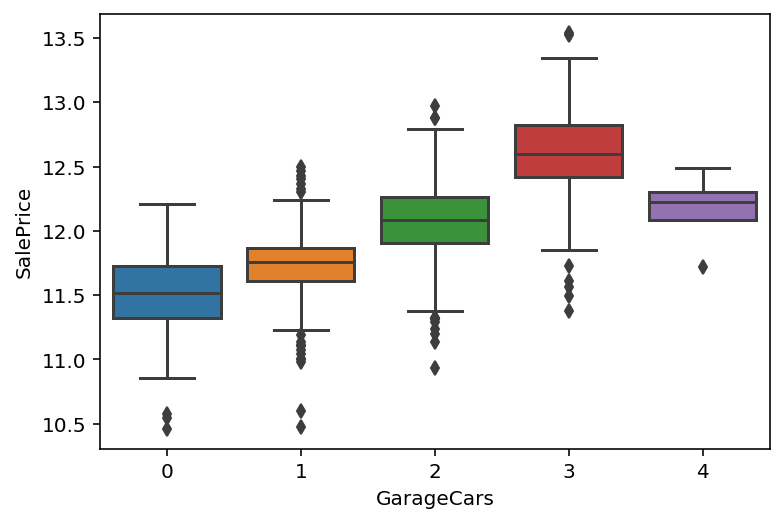

In [22]:
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'])

In [23]:
train = train.drop(train[(train['GarageCars']>3) & (train['SalePrice']<12.5)].index).reset_index(drop=True)
print(f"corr : {round(train['GarageCars'].corr(train['SalePrice']),2)}")

corr : 0.69


* #### WoodDeckSF ( surface du plancher en bois ) 

corr : 0.34


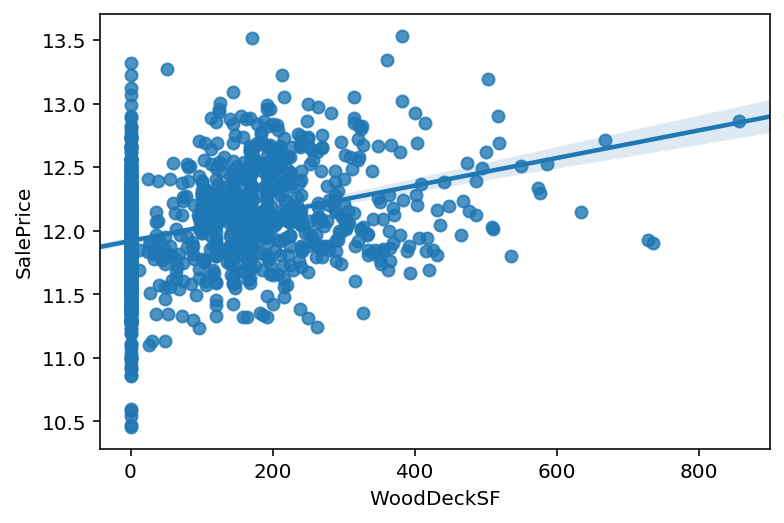

In [24]:
sns.regplot(x='WoodDeckSF',y='SalePrice', data=train)
print(f"corr : {round(train['WoodDeckSF'].corr(train['SalePrice']),2)}")
      

In [25]:
train = train.drop(train[(train['WoodDeckSF']>600) & (train['SalePrice']<12)].index).reset_index(drop=True)
print(f"corr : {round(train['WoodDeckSF'].corr(train['SalePrice']),2)}")

corr : 0.35


* #### OpenPorchSF

corr : 0.33


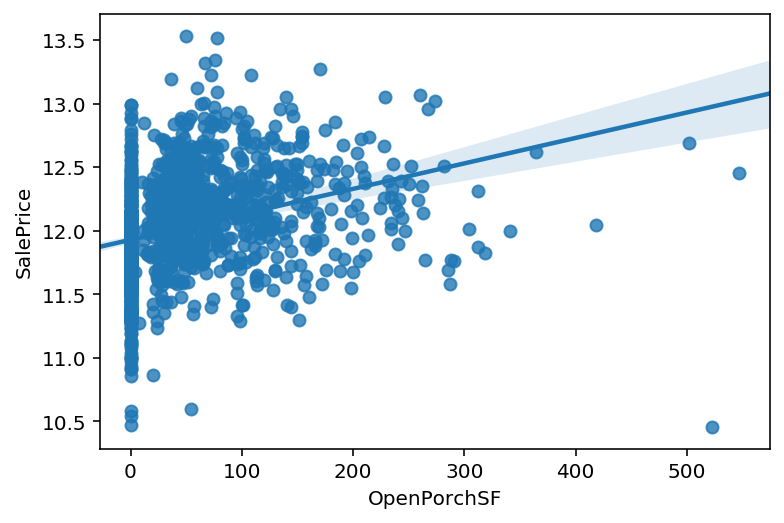

In [26]:
sns.regplot(x='OpenPorchSF',y='SalePrice', data=train)
print(f"corr : {round(train['OpenPorchSF'].corr(train['SalePrice']),2)}")

In [27]:
train = train.drop(train[(train['OpenPorchSF']>500) & (train['SalePrice']<11)].index).reset_index(drop=True)
print(f"corr : {round(train['OpenPorchSF'].corr(train['SalePrice']),2)}")

corr : 0.36


In [28]:
# sns.boxplot(x=train['TotRmsAbvGrd'], y=train['SalePrice'])
# print(f"corr : {round(train['TotRmsAbvGrd'].corr(train['SalePrice']),2)}")

Globalement on amélioré les corrélations des features fortement corrélés avec le prix de vente en supprimant les outliers 


In [29]:
print(train.shape)
print(f"Supression de {1460-1444} outliers")

(1444, 80)
Supression de 16 outliers


## Traitement des valeurs manquantes dans le dataset

On combine les deux datasets pour traiter les valeurs manquantes d'un seul coup

In [30]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
datas = pd.concat((train, test)).reset_index(drop=True)
datas.drop(['SalePrice'], axis=1, inplace=True)

print(train.shape)
print(test.shape)
print(datas.shape)

(1444, 80)
(1459, 79)
(2903, 79)


### %Valeurs manquantes dans le dataset

In [31]:
hasNAN = round((datas.isnull().sum() / len(datas)) * 100,2)  # toutes les features et leurs nombres de zéros ( % )
hasNAN = hasNAN[hasNAN > 0] # On enleve celles qui n'ont pas de valeurs nulles 
hasNAN = hasNAN.sort_values(ascending=False)
missing_values = pd.DataFrame({'Missing Ratio': hasNAN})
missing_values

,Missing Ratio
PoolQC,99.69
MiscFeature,96.49
Alley,93.21
Fence,80.43
FireplaceQu,48.71
LotFrontage,16.64
GarageQual,5.44
GarageCond,5.44
GarageFinish,5.44
GarageYrBlt,5.44


In [32]:
# Exemple pour voir le nombre de NA par features et la distribution des valeurs
# print(datas['MSZoning'].isnull().sum())
# print(datas['MSZoning'].value_counts())

Il faudra traiter tout les NA des features suivantes au cas par cas 
- *PoolQC* : Pool Quality NA = No Pool
- *MiscFeature* : Elements non couverts dans les autres catégories , Na = None 
- *Alley*	: Na = No alley 
- *Fence*	: ( Cloture ) Na = No Fence 
- *FireplaceQu*	: Na = No Fireplace 
- *LotFrontage* : Na = valeur médiane des LotFrontage ( surface de rue reliés à la propriété = trotoir ? ) du quartier
- *GarageQual* , GarageCond, GarageFinish, GarageType :  NA = No Garage ( qual )
- *GarageYrBlt* , GarageCars , GarageArea : Na = No garage , on remplace par zéro ( quan ) 
- *BsmtExposure* , BsmtCond , BsmtQual , BsmtFinType1	, BsmtFinType2  : NA = No Basement
- *BsmtFinSF1* , BsmtFinSF2 , BsmtUnfSF , TotalBsmtSF , BsmtFullBath ,  BsmtHalfBath :  Na = 0 ( No basement ) 
- *MasVnrType* , MasVnrArea : no masonry 0 for area and None for type
- *MSZoning* ( zone de classification de la vente ) : Valeur la plus representé ou par quartier ? ( seulement 4 NA )  
- *Utilities* ( type de services publics dispo ) : Toutes les maisons sont AllPub sauf une , on peut supprimer la feature
- *Functional* : NA = Typ ( valeur la plus représéntée, 2 NA )
- *Electrical* : NA = Sbrkr ( valeur la plus représentée , 1 seul NA ) 	
- *Exterior1st*, Exterior2nd ( revetement extérieur ) 	: 1 seul NA , on remplace par la valeur la plus représentée , VinylSd 
- *KitchenQual* : 1 seul NA , on remplace par TA 
- *SaleType* ( Type de la vente )  : 1 Seul Na , on remplace par WD 


Pour un faible nombre de NaN , interet de remplacer par la valeur la plus représentée du quartier ou la valeur la plus representée de la feature ? 

In [33]:
datas["PoolQC"] = datas["PoolQC"].fillna("None")
datas["MiscFeature"] = datas["MiscFeature"].fillna("None")
datas["Alley"] = datas["Alley"].fillna("None")
datas["Fence"] = datas["Fence"].fillna("None")
datas["FireplaceQu"] = datas["FireplaceQu"].fillna("None")
datas["LotFrontage"] = datas.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    datas[col] = datas[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    datas[col] = datas[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    datas[col] = datas[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    datas[col] = datas[col].fillna('None')
datas["MasVnrType"] = datas["MasVnrType"].fillna("None")
datas["MasVnrArea"] = datas["MasVnrArea"].fillna(0)
datas['MSZoning'] = datas.groupby("Neighborhood")['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
datas = datas.drop(['Utilities'], axis=1)
datas["Functional"] = datas["Functional"].fillna("Typ")
datas['Electrical'] = datas['Electrical'].fillna(datas['Electrical'].mode()[0])
datas['KitchenQual'] = datas['KitchenQual'].fillna(datas['KitchenQual'].mode()[0])
datas['Exterior1st'] = datas['Exterior1st'].fillna(datas['Exterior1st'].mode()[0])
datas['Exterior2nd'] = datas['Exterior2nd'].fillna(datas['Exterior2nd'].mode()[0])
datas['SaleType'] = datas['SaleType'].fillna(datas['SaleType'].mode()[0])
datas['MSSubClass'] = datas['MSSubClass'].fillna("None")

In [34]:
hasNAN = round((datas.isnull().sum() / len(datas)) * 100,2)  # toutes les features et leurs nombres de zéros ( % )
hasNAN = hasNAN[hasNAN > 0] # On enleve celles qui n'ont pas de valeurs nulles 
hasNAN = hasNAN.sort_values(ascending=False)
missing_values = pd.DataFrame({'Missing Ratio': hasNAN})
missing_values

,Missing Ratio


Il n'y a plus de valeurs manquantes 

## Modifications de features
Certaines features qualitatives sont en fait des rangs et peuvent etre transformer en feature numérique

LabelEncode ou faire ca à la main ? Est ce important d'avoir un ordre numérique explicitant la qualité de la cuisine par exemple ? 

get_dummies() sur les variables qualitatives restantes ( qui ne semblent pas indiquer un classement ? )
Supprimer la dernier colonne ( approfondir dummy variable trap ) 


* Ajouts / Modifications de features
#### PoolArea n'a pas d'impact sur le prix de vente , Supprimer PoolQC/PoolArea => Pool : 0 / 1


In [35]:
datas.Alley = datas.Alley.map({'None':0, 'Grvl':1, 'Pave':2})
datas.BsmtCond =  datas.BsmtCond.map({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
datas.BsmtExposure = datas.BsmtExposure.map({'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})
datas['BsmtFinType1'] = datas['BsmtFinType1'].map({'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
datas['BsmtFinType2'] = datas['BsmtFinType2'].map({'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
datas.BsmtQual = datas.BsmtQual.map({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
datas.ExterCond = datas.ExterCond.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
datas.ExterQual = datas.ExterQual.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
datas.FireplaceQu = datas.FireplaceQu.map({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
datas.Functional = datas.Functional.map({'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8})
datas.GarageCond = datas.GarageCond.map({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
datas.GarageQual = datas.GarageQual.map({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
datas.HeatingQC = datas.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
datas.KitchenQual = datas.KitchenQual.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
datas.LandSlope = datas.LandSlope.map({'Sev':1, 'Mod':2, 'Gtl':3}) 
datas.PavedDrive = datas.PavedDrive.map({'N':1, 'P':2, 'Y':3})
datas.PoolQC = datas.PoolQC.map({'None':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
datas.Street = datas.Street.map({'Grvl':1, 'Pave':2})
datas.GarageFinish = datas.GarageFinish.map(({'None':0 ,'Unf':1 ,'RFn':2, 'Fin':3}))
datas.CentralAir = datas.CentralAir.map(({'N':0 ,'Y':1}))

# quanti => quali
datas.MSSubClass = datas.MSSubClass.map({20:'class1', 30:'class2', 40:'class3', 45:'class4',
                                   50:'class5', 60:'class6', 70:'class7', 75:'class8',
                                   80:'class9', 85:'class10', 90:'class11', 120:'class12',
                                   150:'class13', 160:'class14', 180:'class15', 190:'class16'})

#### Mise à jour features quali/quanti

In [36]:
newquan = pd.Index(['Alley','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtQual',
           'ExterCond','ExterQual','FireplaceQu','Functional','GarageCond',
           'GarageQual','HeatingQC','KitchenQual','LandSlope','PavedDrive','PoolQC',
           'Street','GarageFinish','CentralAir'])

newqual = pd.Index(['MSSubClass'])

In [37]:
quan

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [38]:
quan = quan.append(newquan)
quan = quan.drop(newqual)

In [39]:
qual = qual.drop(newquan)
qual = qual.append(newqual)
qual = qual.drop(pd.Index(['Utilities']))

In [40]:
print(f"{len(quan)} features quantitatives")

55 features quantitatives


In [41]:
print(f"{len(qual)} features qualitatives")

23 features qualitatives


In [42]:
quan

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'ExterCond', 'ExterQual', 'FireplaceQu',
       'Functional', 'GarageCond', 'GarageQual', 'HeatingQC', 'KitchenQual',
       'LandSlope', 'PavedDrive', 'PoolQC', 'Street', 'GarageFinish',
       'CentralAir'],
      dtype='object')

In [43]:
qual

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'Heating', 'Electrical', 'GarageType', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'MSSubClass'],
      dtype='object')

In [44]:
print(datas.shape)

(2903, 78)


### Dummies variables

In [45]:
datas = pd.get_dummies(datas, columns=qual, drop_first=True)

In [46]:
print(datas.shape)

(2903, 218)


In [47]:
train = datas[:ntrain]
test = datas[ntrain:]

In [48]:
print(train.shape)
print(test.shape)

(1444, 218)
(1459, 218)


In [49]:
X_train = train
X_test = test

### Scaler
On scale le train et le test , si on avait voulu un train / val on aurait du split avant

In [50]:
scaler = RobustScaler()
X_train[quan]= scaler.fit_transform(X_train[quan])
X_test[quan]= scaler.transform(X_test[quan])

### Reste à faire 
- Ajout / Modification de features
- Feature selection 
- Skewness ( boxcox , log  , StandardScaler )
- Cross Validation ( pas besoin de split le train full en train et val )
- Model Selection 

## Fit & Prediction
* Ne pas oublier que tout les prix sont transformés en log1p ( np.expm1 pour avoir les vrais prix ) 
* L'évaluation kaggle se fait selon le RMSE ( Root Mean Squared Error)

### Features Selection

In [51]:
# xgb = XGBRegressor()
# xgb.fit(X_train, y_train)
# imp = pd.DataFrame(xgb.feature_importances_ ,columns = ['Importance'],index = X_train.columns)
# imp = imp.sort_values(['Importance'], ascending = False)

# print(imp)

In [52]:

# # Define a function to calculate RMSE
# def rmse(y_true, y_pred):
#     return np.sqrt(np.mean((y_true-y_pred)**2))

# # Define a function to calculate negative RMSE (as a score)
# def nrmse(y_true, y_pred):
#     return -1.0*rmse(y_true, y_pred)

# neg_rmse = make_scorer(nrmse)

# estimator = XGBRegressor()
# selector = RFECV(estimator, cv = 3, n_jobs = -1, scoring = neg_rmse)
# selector = selector.fit(X_train, y_train)

# print("The number of selected features is: {}".format(selector.n_features_))

# features_kept = X_train.columns.values[selector.support_] 
# X_train = X_train[features_kept]
# X_test = X_test[features_kept]

In [53]:
# features_kept

#### Test XGBRegressor

In [54]:
# model_xgb = xgb.XGBRegressor()
# model_xgb.fit(X_train, y_train)

#### Kernel Ridge

In [55]:
# model_krr = KernelRidge()
# model_krr.fit(X_train, y_train)

#### Ridge Regression

In [56]:
# ridge_reg = Ridge(alpha=1, solver='auto')
# ridge_reg.fit(X_train, y_train)

#### Cross Validation

In [57]:
# scores = cross_val_score(ridge_reg, X_train, y_train, cv=10)
# print(f"rmse moyenne : {scores.mean()}")
# scores.std()

### Essais de plusieurs modeles en meme temps
xgbregressor , kernelridge, Ridge

In [58]:
# def rmse_cv(model):
#     rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5))
#     return rmse

In [59]:

# model_xgb = xgb.XGBRegressor()
# model_krr = KernelRidge()
# model_reg = Ridge(alpha=30.0, solver='svd')
# model_en = ElasticNet()

In [60]:
# scores = rmse_cv(model_xgb)
# print(f"XGBRegressor score : {scores.mean():.4f} ( std : {scores.std():.4f})")
# scores = rmse_cv(model_krr)
# print(f"Kernel Ridge Regressor score : {scores.mean():.4f} ( std : {scores.std():.4f})")
# scores = rmse_cv(model_reg)
# print(f"Ridge Regressor score : {scores.mean():.4f} ( std : {scores.std():.4f})")
# scores = rmse_cv(model_en)
# print(f"Ridge Regressor score : {scores.mean():.4f} ( std : {scores.std():.4f})")

#### GridSearch 

In [73]:
ridge = Ridge()

param_grid = [
    {'solver' : ['auto','svd','cholesky','lsqr','sparse_cg','sag','saga'], 'alpha':[20.0,21.0,22.0], 'copy_X' :[True, False]}
    ]
grid_search = GridSearchCV(ridge,param_grid,cv=10, scoring='neg_mean_squared_error' ,return_train_score=True)

grid_search.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'], 'alpha': [20.0, 21.0, 22.0], 'copy_X': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [62]:
grid_search.best_params_
grid_search.best_estimator_

Ridge(alpha=20.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='svd', tol=0.001)

#### Prédictions

In [74]:
# y_val_kaggle = np.expm1(model_xgb.predict(X_test))
# y_val_kaggle = np.expm1(model_krr.predict(X_test))
y_val_kaggle = np.expm1(grid_search.best_estimator_.predict(X_test))

In [ ]:
#Csv


# d = {'Id':test_ID, 'SalePrice':y_val_kaggle}
# sub = pd.DataFrame(data=d)
# sub.to_csv('KernelRidge_RobustScaler.csv', index=False)

## Submission Kaggle

In [75]:
d = {'Id':test_ID, 'SalePrice':y_val_kaggle}
sub = pd.DataFrame(data=d)
sub.to_csv('house_prices_pred.csv', index=False)

submission_file = 'house_prices_pred.csv'
kaggle.api.competition_submit(submission_file, "Ridge Hyperparametres ( solver , alpha ))", "house-prices-advanced-regression-techniques")


100%|██████████| 33.7k/33.7k [00:05<00:00, 5.98kB/s]


Successfully submitted to House Prices: Advanced Regression Techniques